In [1]:
!pip install pytesseract opencv-python matplotlib

In [2]:
import numpy as np
import pytesseract
import io
import xml.etree.cElementTree as ET
import cv2

from matplotlib import pyplot as plt

In [3]:
image_path = "text_sample2.png"
hocr = pytesseract.image_to_pdf_or_hocr(image_path, extension='hocr', lang='rus+eng')
hocr

b'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n <head>\n  <title></title>\n  <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>\n  <meta name=\'ocr-system\' content=\'tesseract 5.3.4\' />\n  <meta name=\'ocr-capabilities\' content=\'ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf\'/>\n </head>\n <body>\n  <div class=\'ocr_page\' id=\'page_1\' title=\'image "/home/jovyan/text_sample2.png"; bbox 0 0 1461 318; ppageno 0; scan_res 96 96\'>\n   <div class=\'ocr_carea\' id=\'block_1_1\' title="bbox 414 68 1013 104">\n    <p class=\'ocr_par\' id=\'par_1_1\' lang=\'rus\' title="bbox 414 68 1013 104">\n     <span class=\'ocr_line\' id=\'line_1_1\' title="bbox 414 68 1013 104; baseline 0 -8; x_size 37; x_descenders 9; x_ascenders 7">\n      <span class=\'ocrx_word\' id=\'word_1_1\'

In [4]:
tree = ET.parse(io.BytesIO(hocr))
root = tree.getroot()
elems = root.findall('.//{http://www.w3.org/1999/xhtml}span[@class="ocr_line"]')

In [5]:
elems[1].text

'\n      '

In [6]:
def get_bbox(elem):
    title_parts = elem.attrib['title'].split(';')
    bbox = list(filter(lambda el: el.startswith('bbox'), title_parts))[0]
    return list(map(int, bbox.split(' ')[1:]))
    
bbox = get_bbox(elems[0])
bbox

[414, 68, 1013, 104]

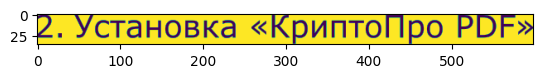

In [7]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def crop_elem(elem, img):
    coords = get_bbox(elem)
    return img[coords[1]:coords[3], coords[0]:coords[2]]
    
subimg = crop_elem(elems[0], img)

plt.imshow(subimg)
plt.show()

In [8]:
def is_white(img):
    return np.sum(img < 255) == 0

def get_thickness(img):
    i = 0
    while not is_white(img):
        i += 1
        img = 255-cv2.erode(255-img, kernel=np.ones((3, 3)))
    return i

get_thickness(subimg)

4

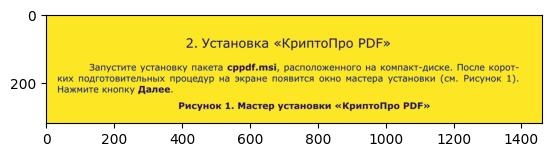

In [9]:
plt.imshow(img)
plt.show()

In [10]:
def get_size(elem):
    title_parts = elem.attrib['title'].split('; ')
    size = list(filter(lambda part: part.startswith('x_size'), title_parts))[0]
    return float(size.split(' ')[1])

In [11]:
for par in root.findall('.//{http://www.w3.org/1999/xhtml}p[@class="ocr_par"]'):
    print(par.attrib['id'])
    for elem in par.findall('.//{http://www.w3.org/1999/xhtml}span[@class="ocr_line"]'):
        subimg = crop_elem(elem, img)
        words = elem.findall(".//{http://www.w3.org/1999/xhtml}span[@class='ocrx_word']")
        text = " ".join(map(lambda wrd: wrd.text, words))
        size = get_size(elem)
        print({'text': text, 'thickness': get_thickness(subimg), 'size': size})

par_1_1
{'text': '2. Установка «КриптоПро PDF»', 'thickness': 4, 'size': 37.0}
par_1_2
{'text': 'Запустите установку пакета cppdf.msi, расположенного на компакт-диске. После корот-', 'thickness': 4, 'size': 27.5}
{'text': 'ких подготовительных процедур на экране появится окно мастера установки (см. Рисунок 1).', 'thickness': 3, 'size': 27.5}
{'text': 'Нажмите кнопку Далее.', 'thickness': 4, 'size': 25.0}
par_1_3
{'text': 'Рисунок 1. Мастер установки «КриптоПро PDF»', 'thickness': 6, 'size': 26.0}
